# Imports

In [50]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn.functional import one_hot
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Key PyTorch Features

## Creating a Computational Graph in PyTorch

In [2]:
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

print(f'Scalar Inputs: {compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3))}')
print(f'Rank 1 Inputs: {compute_z(torch.tensor([1]), torch.Tensor([2]), torch.Tensor([3]))}')
print(f'Rank 2 Inputs: {compute_z(torch.tensor([[1]]), torch.Tensor([[2]]), torch.Tensor([[3]]))}')

Scalar Inputs: 1
Rank 1 Inputs: tensor([1.])
Rank 2 Inputs: tensor([[1.]])


## Random Weight Initialization w/ Glorot Init

In [3]:
torch.manual_seed(1)

w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [4]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

## Computing Gradients via Automatic Differentiation

In [5]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(.5,  requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y - z).pow(2).sum()
loss.backward()

print(f'dL/dw :', w.grad)
print(f'dL/db :', b.grad)
print(2 * x * ((w * x + b) - y))

dL/dw : tensor(-0.5600)
dL/db : tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)


## Implementing Models Based on nn.Sequential

In [6]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [7]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = .01
l1_penalty = l1_weight * model[2].weight.abs().sum()

## Solving an XOR Classification Problem

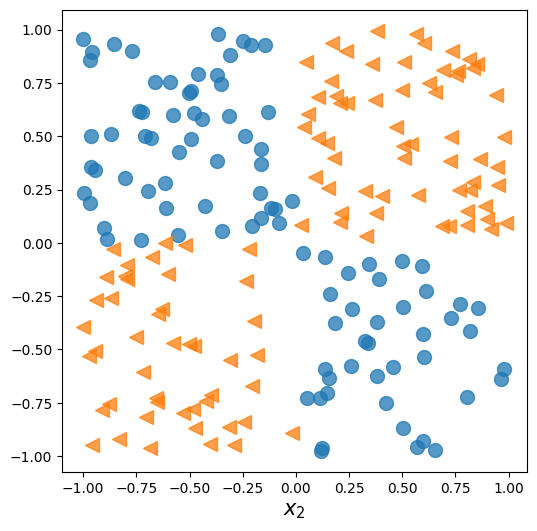

In [8]:
torch.manual_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))

''' 
    In this case, our truth labels are 0 if 
    the product of x1 and x2 (our features) 
    is less than 0. Otherwise, they're 1.
'''
y[x[:, 0] * x[:, 1] < 0] = 0

n_train = 100

x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train]   , dtype=torch.float32)

x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:]   , dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))

plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=.75, markersize=10)

plt.xlabel(r'$x_1$', size=15)
plt.xlabel(r'$x_2$', size=15)

plt.show()

In [9]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200

def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in tqdm(range(num_epochs), leave=False, desc='Epoch'):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

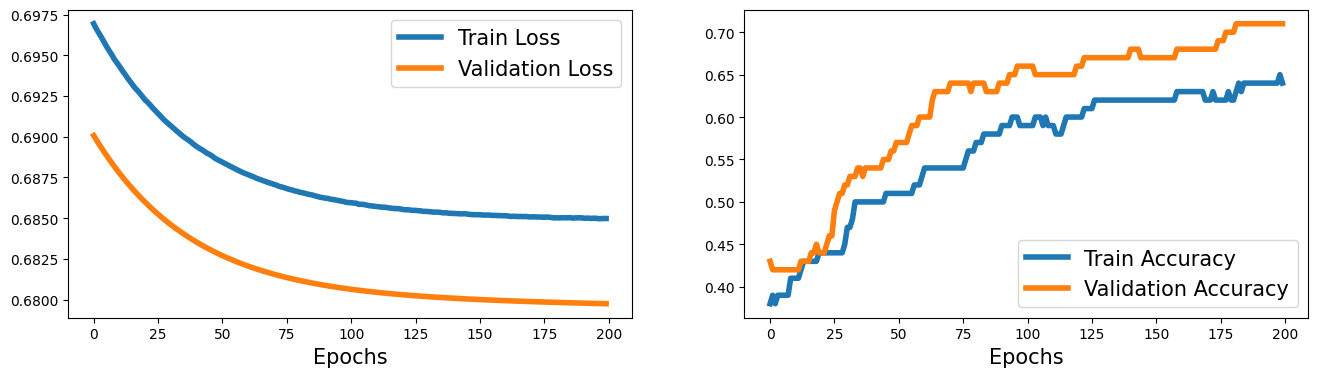

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)

plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)

plt.legend(['Train Loss', 'Validation Loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)

plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)

plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

''' 
    We can see that since we only had one layer, our model was unable to 
    derive a linear decision boundary. We can resolve this by adding either
    more hidden layers (increasing the depth) or more hidden units (increasing the width).
    
    Next code block plays around with that
'''
print()

### Adding another hidden layer and some more hidden units to derive a non-linear decison boundary

' \n    We now have a non linear decision boundary as our accuracy has gone up,\n    but we still have some overfitting\n'

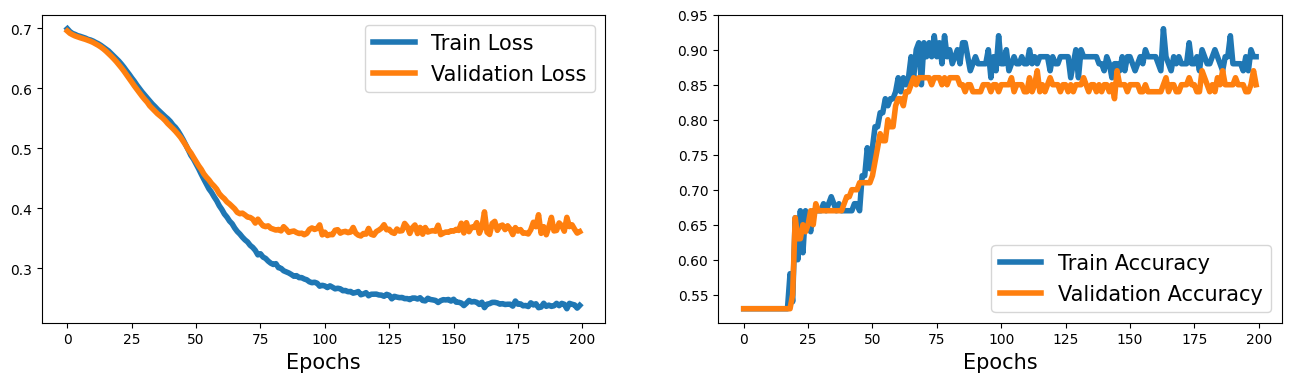

In [11]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.015)

history = train(model, num_epochs, train_dl, x_valid, y_valid)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)

plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)

plt.legend(['Train Loss', 'Validation Loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)

plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)

plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

''' 
    We now have a non linear decision boundary as our accuracy has gone up,
    but we still have some overfitting
'''

## Increasing Model Building Flexibility with nn.Module

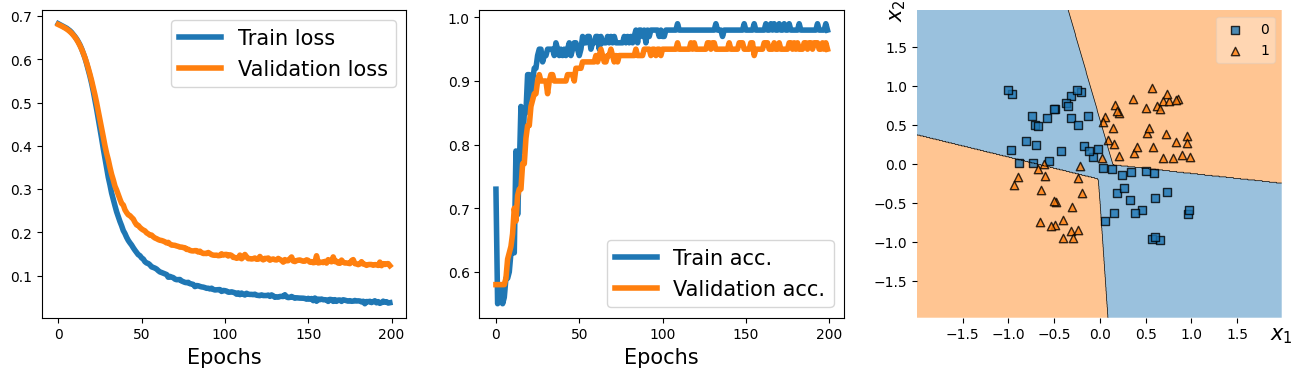

In [12]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

## Creating a Custom Layer in PyTorch

In [15]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)   

In [16]:
torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))
 
print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


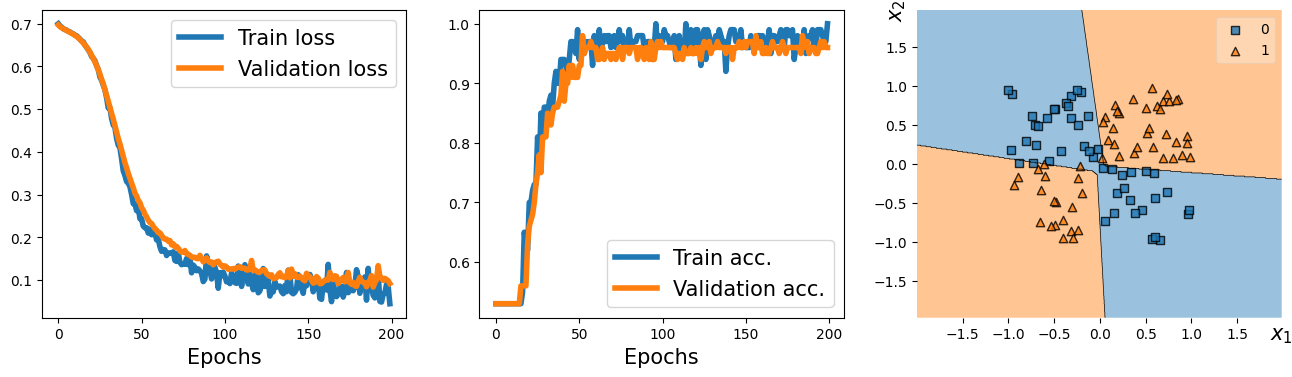

In [17]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
    
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

# Project One - Predicting Fuel Efficiency of a Car

### Loading Data

In [19]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower',
    'Weight', 'Acceleration', 'Model Year', 'Origin'
]

df = pd.read_csv(
    url, 
    names=column_names, 
    na_values="?",  
    comment='\t', 
    sep=' ', 
    skipinitialspace=True
)

df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Train Test Split

In [22]:
df_train, df_test = train_test_split(df, train_size=.8, random_state=1)
train_stats = df.describe().transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.00,22.75,29.00,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.00,4.00,8.00,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.00,151.00,275.75,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.00,93.50,126.00,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.25,2803.50,3614.75,5140.0


### Data Preprocessing

#### Apply Normalization to numeric columns

In [23]:
numeric_column_names = [
    'Cylinders', 'Displacement', 'Horsepower',
    'Weight', 'Acceleration'
]

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col in numeric_column_names:
    
    mean = train_stats.loc[col, 'mean']
    std  = train_stats.loc[col, 'std']
    
    df_train_norm.loc[:, col] = (df_train_norm.loc[:, col] - mean) / std
    df_test_norm.loc[:, col] = (df_test_norm.loc[:, col] - mean) / std
    
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.862911,-0.930889,-0.765614,-0.968427,0.311242,76,3
255,19.4,0.309571,0.359199,-0.375915,0.273623,0.601216,78,1
72,13.0,1.482053,1.075915,0.663285,1.319063,-0.558682,72,1
235,30.5,-0.862911,-0.921333,-1.077374,-1.090866,0.528722,77,1
37,14.0,1.482053,1.486832,1.572585,1.449743,-1.283618,71,1


#### Bucketizing our Model Year (Ordinal Categorical Data)

In [37]:
boundaries = torch.tensor([73, 76, 79])
 
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

df_train_norm.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Model Year Bucketed
334,27.2,-0.862911,-0.567753,-0.531795,-0.574032,0.057514,81,1,3
258,18.6,0.309571,0.292305,0.143685,0.756315,1.144918,78,1,2
139,29.0,-0.862911,-0.921333,-0.557775,-0.893080,0.347488,74,2,1
310,37.2,-0.862911,-1.036008,-1.025414,-1.128539,0.311242,80,3,3
349,33.0,-0.862911,-0.854440,-0.791594,-0.927221,-0.486188,81,2,3


#### One Hot Encoding Origin

In [45]:
total_origin = df_train_norm['Origin'].unique().size

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)

x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)

x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test  = torch.tensor(df_test_norm['MPG'].values).float()

### Training a Deep Neural Network (DNN) Regression Model

In [49]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
hidden_units = [8, 4]
input_size = x_train.shape[1]
all_layers = []

for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit
    
all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):
    
    loss_hist_train = 0
    
    for x_batch, y_batch in train_dl:
        
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        loss_hist_train += loss.item()
    
    if epoch % log_epochs == 0 :
        print(f'Epoch {epoch} Loss: {loss_hist_train/len(train_dl) : .4f}')
        
with torch.no_grad():
    
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    
    print(f'Test MSE: {loss.item() : .4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, y_test).item() : .4f}')

Epoch 0 Loss:  562.9855
Epoch 20 Loss:  8.3722
Epoch 40 Loss:  7.7520
Epoch 60 Loss:  7.5490
Epoch 80 Loss:  7.1988
Epoch 100 Loss:  7.0200
Epoch 120 Loss:  6.7053
Epoch 140 Loss:  7.0646
Epoch 160 Loss:  7.7997
Epoch 180 Loss:  6.6885
Test MSE:  8.6708
Test MAE:  1.9893


# Project Two - Classifying MNIST Handwritten Digits

## Loading the MNIST Dataset with Torchvision

In [57]:
image_path = '../data/'

transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(
    train=True, 
    download=False,
    root=image_path, 
    transform=transform, 
)
mnist_test_dataset  = torchvision.datasets.MNIST(
    train=False, 
    download=False,
    root=image_path, 
    transform=transform, 
)

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

## Building Our Model

In [58]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]
all_layers = [nn.Flatten()]

for hidden_unit in hidden_units:
    
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit
    
all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

## Usage

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
torch.manual_seed(1)

num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

Epoch 0  Accuracy 0.8531
Epoch 1  Accuracy 0.9287
Epoch 2  Accuracy 0.9413
Epoch 3  Accuracy 0.9506
Epoch 4  Accuracy 0.9558
Epoch 5  Accuracy 0.9592
Epoch 6  Accuracy 0.9627
Epoch 7  Accuracy 0.9650
Epoch 8  Accuracy 0.9674
Epoch 9  Accuracy 0.9690
Epoch 10  Accuracy 0.9710
Epoch 11  Accuracy 0.9729
Epoch 12  Accuracy 0.9739
Epoch 13  Accuracy 0.9750
Epoch 14  Accuracy 0.9764
Epoch 15  Accuracy 0.9777
Epoch 16  Accuracy 0.9779
Epoch 17  Accuracy 0.9798
Epoch 18  Accuracy 0.9806
Epoch 19  Accuracy 0.9813


## Evaluation

In [60]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9647
